In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagGPTAlibiEstimator

[2023-08-08 13:24:50,596] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
dataset = get_dataset("electricity")

In [15]:
estimator = LagGPTAlibiEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    
    scaling="std",
    # rope_scaling=dict(type="linear", factor=2.0),
    # nhead=2,
    n_layer=4,
    # num_decoder_layers=2,
    # dim_feedforward=16,
    # activation="gelu",
    
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=50),
    
)

In [16]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | LagGPTAlibiModel | 117 K 
-------------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.66570 (best 5.66570), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi/lightning_logs/version_8/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.41081 (best 5.41081), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi/lightning_logs/version_8/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.35345 (best 5.35345), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi/lightning_logs/version_8/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.33433 (best 5.33433), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi/lightning_logs/version_8/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.25845 (best 5.25845), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [18]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [19]:
evaluator = Evaluator()

In [20]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 2247it [00:00, 29087.83it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

In [21]:
agg_metrics

{'MSE': 1514494.243012245,
 'abs_error': 7089552.617504809,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6431802394533255,
 'MAPE': 0.08121775967140576,
 'sMAPE': 0.09199923920827703,
 'MSIS': 5.283279417374151,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3218172.5909498297,
 'Coverage[0.1]': 0.06415962023438658,
 'QuantileLoss[0.2]': 4963493.516449882,
 'Coverage[0.2]': 0.14751149681056222,
 'QuantileLoss[0.3]': 6091739.914683902,
 'Coverage[0.3]': 0.24056148939326513,
 'QuantileLoss[0.4]': 6792273.589474481,
 'Coverage[0.4]': 0.3408804331701528,
 'QuantileLoss[0.5]': 7089552.658679519,
 'Coverage[0.5]': 0.44475967957276363,
 'QuantileLoss[0.6]': 7042581.06100413,
 'Coverage[0.6]': 0.5411103693813974,
 'QuantileLoss[0.7]': 6541275.698355446,
 'Coverage[0.7]': 0.6485684616525739,
 'QuantileLoss[0.8]': 5577866.018554035,
 'Coverage[0.8]': 0.7580848538792463,
 'QuantileLoss[0.9]': 3908480.447351634,
 

In [19]:
agg_metrics

{'MSE': 1699353.3605744469,
 'abs_error': 7915254.201302687,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.673017229115215,
 'MAPE': 0.0925330129097111,
 'sMAPE': 0.09874831644566463,
 'MSIS': 5.436230429382124,
 'QuantileLoss[0.1]': 3191534.9403455807,
 'Coverage[0.1]': 0.08442738466102952,
 'QuantileLoss[0.2]': 5158144.203989559,
 'Coverage[0.2]': 0.1815198041833556,
 'QuantileLoss[0.3]': 6537250.36521844,
 'Coverage[0.3]': 0.2831367749592048,
 'QuantileLoss[0.4]': 7449845.689399119,
 'Coverage[0.4]': 0.3864040943480196,
 'QuantileLoss[0.5]': 7915254.207095364,
 'Coverage[0.5]': 0.49195223260643817,
 'QuantileLoss[0.6]': 7986841.531431158,
 'Coverage[0.6]': 0.5835929387331257,
 'QuantileLoss[0.7]': 7462329.538075933,
 'Coverage[0.7]': 0.6905689066904019,
 'QuantileLoss[0.8]': 6362337.498570402,
 'Coverage[0.8]': 0.7890149829402165,
 'QuantileLoss[0.9]': 4403064.440043806,
 'Coverage[0.9]': 0.8873127132472927,


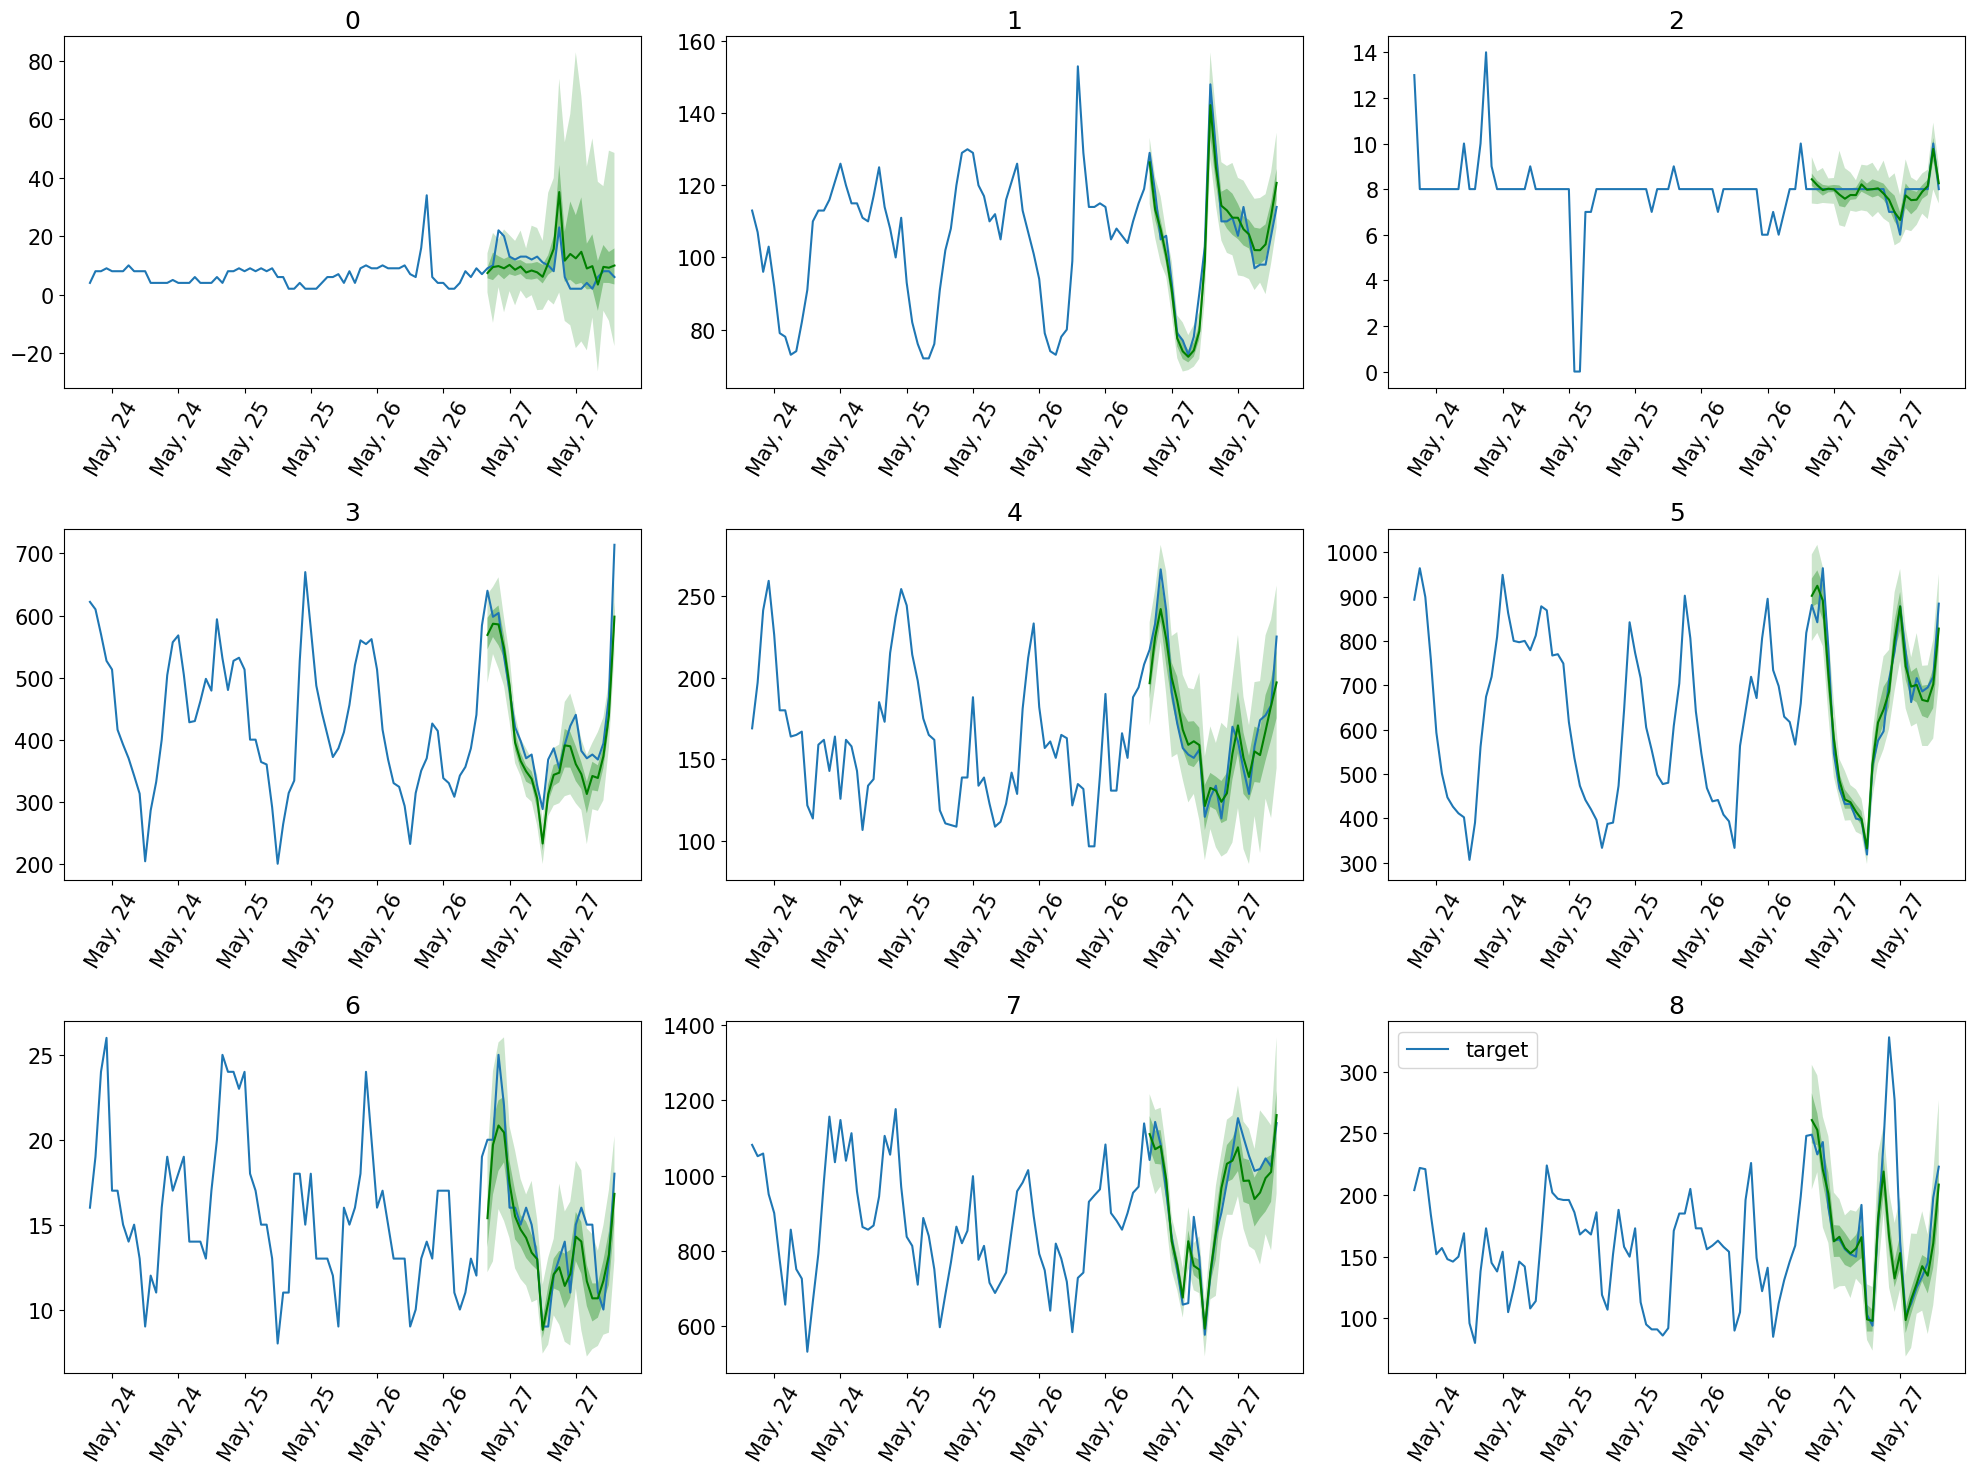

In [22]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
crpss = []
for i in range(79):
    estimator = LagGPTAlibiEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        
        scaling="std",
        # rope_scaling=dict(type="linear", factor=2.0),
        n_layer=4,
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=0),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt-alibi/lightning_logs/version_8/checkpoints/epoch=42-step=4300.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    crpss.append(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | LagGPTAlibiModel | 117 K 
-------------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 30505.95it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND

In [ ]:
plt.plot([(i+1)*24 for i in range(len(crpss))], crpss)
plt.xlabel("context_length")
plt.ylabel("CRPS")